# Preparation
Import the modules:

In [1]:
import time
import os
from math import log
import numpy as np
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings('ignore')

Initial parameters:

In [48]:
ALL_DATASETS_PATH = './datasets/'
n_grams = [1, 2, 3]
alphas = [0.00001, 0.0002, 0.005, 38]
lambdas = [10 ** x for x in range(0, 301, 50)]
weights = [0.5, 1.0, 1.5]

Function for reading from a file:

In [3]:
def split(text, n_gram_size):
    return [tuple([text[i + q] for q in range(n_gram_size)]) for i in range(len(text) - n_gram_size)]


def splitter(overlooked, n_gram_size):
    folders = os.listdir(ALL_DATASETS_PATH)
    test, train = [], []
    for folder in folders:
        datasets_path = ALL_DATASETS_PATH + folder
        files = os.listdir(datasets_path)
        for file in files:
            f = open(datasets_path + '/' + file, 'r')
            subject = np.array([int(num) for num in f.readline().split()[1:]])
            f.readline()
            text = split(np.array([int(num) for num in f.readline().split()]), n_gram_size)
            add = np.array([subject, text, 'spmsg' in file])
            if 'part' + str(overlooked) == folder:
                test.append(add)
            else:
                train.append(add)
    return np.array(test), np.array(train)

Frequency counting

In [4]:
def frequency(trains, alpha):
    frequencies_subjects, frequencies_texts = [{}, {}], [{}, {}]
    n_gram_count = 0
    letter_type_count = np.zeros(2, dtype=float)
    for letter in trains:
        n_gram_count += len(letter[1])
        letter_type = letter[2]
        letter_type_count[letter_type] += 1
        for n_gram in letter[0]:
            if frequencies_subjects[letter_type].get(n_gram) is None:
                frequencies_subjects[letter_type][n_gram] = 0.0
            frequencies_subjects[letter_type][n_gram] += 1.0
        for n_gram in letter[1]:
            if frequencies_texts[letter_type].get(n_gram) is None:
                frequencies_texts[letter_type][n_gram] = 0.0
            frequencies_texts[letter_type][n_gram] += 1.0
    letter_type_count /= len(trains)
    frequencies_texts = [{k: v / n_gram_count for (k, v) in frequencies_texts[i].items()} for i in range(2)]
    return frequencies_subjects, frequencies_texts, letter_type_count, alpha / n_gram_count

# Analysis for bayes
Find the best combination of hyperparameters:

In [5]:
def get(frequencies, ind):
    val = frequencies.get(ind)
    return 0 if val is None else val


def classifier(tests, params, cur_lambdas, cur_weight):
    frequencies_subjects, frequencies_texts, letter_type_count, alpha = params
    ans = []
    for test in tests:
        letter_types = []
        for letter_type in range(2):
            cur_val = log(letter_type_count[letter_type] * cur_lambdas[letter_type])
            for n_gram in test[0]:
                cur_val += cur_weight * log(get(frequencies_subjects[letter_type], n_gram) + alpha)
            for n_gram in test[1]:
                cur_val += log(get(frequencies_texts[letter_type], n_gram) + alpha)
            letter_types.append((cur_val, letter_type))
        letter_types.sort(reverse=True)
        ans.append(letter_types[0][1])
    return ans

In [6]:
def calc_f_measure(confusion_matrix):
    size = len(confusion_matrix)
    precision = sum([confusion_matrix[i][i] / max(sum(confusion_matrix[i]), 0.01) for i in range(size)]) / size
    recall = sum([confusion_matrix[i][i] / max(sum(confusion_matrix[:, i]), 0.01) for i in range(size)]) / size
    return 2 * precision * recall / (precision + recall)


def calc_accuracy(confusion_matrix):
    size = len(confusion_matrix)
    tp = confusion_matrix[0][0]
    tn = confusion_matrix[1][1]
    total = sum([sum(confusion_matrix[i]) for i in range(size)])
    return (tp + tn) / total


def find_best():
    results = []
    for n_gram in n_grams:
        for alpha in alphas:
            for cur_lambda in lambdas:
                for cur_weight in weights:
                    print('Cur params: n_gram=' + str(n_gram)
                          + ', alpha=' + str(alpha)
                          + ', cur_lambda=' + str(cur_lambda)
                          + ', cur_weight=' + str(cur_weight))
                    ls, scores = [], []
                    for num_part in range(1, 11):
                        tests, trains = splitter(num_part, n_gram)
                        classified = classifier(tests, frequency(trains, alpha), [1.0, 1.0 * cur_lambda], cur_weight)
                        confusion_matrix = np.zeros((2, 2))
                        for i in range(len(classified)):
                            confusion_matrix[classified[i]][int(tests[i][2])] += 1
                        ls.append(confusion_matrix[0][1] / len(classified))
                        scores.append(calc_accuracy(confusion_matrix))
                    results.append([n_gram, alpha, cur_lambda, cur_weight, np.average(ls), np.average(scores)])
    return np.array(results), min(results, key=lambda x: x[4]), max(results, key=lambda x: x[5])

In [45]:
def cord(results):
    xs, ys = [], []
    min_res = min(results, key=lambda x: x[1])
    max_res = max(results, key=lambda x: x[1])
    qty_false = sum([x == 0 for x in results[:, 0]])
    qty_true = sum([x == 1 for x in results[:, 0]])
    border = min_res[1]
    step = (max_res[1] - min_res[1]) / 100
    while border <= max_res[1]:
        up_border = list(filter(lambda x: x[1] >= border, results))
        up_border_qty_true = len(list(filter(lambda x: x[0] == 1, up_border)))
        xs.append((len(up_border) - up_border_qty_true) / float(qty_false))
        ys.append(up_border_qty_true / float(qty_true))
        border += step
    return xs, ys


def probabilities(tests, params, cur_lambdas, cur_weight):
    frequencies_subjects, frequencies_texts, letter_type_count, alpha = params
    ans = []
    for test in tests:
        val_false = log(letter_type_count[0] * cur_lambdas[0])
        val_true = log(letter_type_count[1] * cur_lambdas[1])
        for n_gram in test[0]:
            val_false += cur_weight * log(get(frequencies_subjects[0], n_gram) + alpha)
            val_true += cur_weight * log(get(frequencies_subjects[1], n_gram) + alpha)
        for n_gram in test[1]:
            val_false += log(get(frequencies_texts[0], n_gram) + alpha)
            val_true += log(get(frequencies_texts[1], n_gram) + alpha)
        ans.append(val_true / val_false if val_true > 0 and val_false > 0 else (
            0 if val_true == 0 else val_false / val_true))
    return ans

In [110]:
def plot_lambda(results):
    results = results[np.argsort(results[:, 2])]
    xs = results[:, 2]
    ls = results[:, 4]
    assessment = results[:, 5]
    
    fig, axs = plt.subplots(1, 2, figsize=(12, 6))
    axs[0].plot(xs, ls, '-')
    axs[0].set_xlabel('Lambda')
    axs[0].set_ylabel('Percentage of legitimate classified as spam')
    axs[0].grid(True)
    axs[1].plot(xs, assessment, ':')
    axs[1].set_xlabel('Lambda')
    axs[1].set_ylabel('Accuracy')
    axs[1].grid(True)
    fig.suptitle('Dependency plots')
    fig.show()

In [70]:
def find_best_short():
    results = []
    for n_gram in [2]:
        for alpha in [1]:
            for cur_lambda in lambdas:
                for cur_weight in [1]:
                    print('Cur params: n_gram=' + str(n_gram)
                          + ', alpha=' + str(alpha)
                          + ', cur_lambda=' + str(cur_lambda)
                          + ', cur_weight=' + str(cur_weight))
                    ls, scores = [], []
                    for num_part in range(1, 11):
                        tests, trains = splitter(num_part, n_gram)
                        classified = classifier(tests, frequency(trains, alpha), [1.0, 1.0 * cur_lambda], cur_weight)
                        confusion_matrix = np.zeros((2, 2))
                        for i in range(len(classified)):
                            confusion_matrix[classified[i]][int(tests[i][2])] += 1
                        ls.append(confusion_matrix[0][1] / len(classified))
                        scores.append(calc_accuracy(confusion_matrix))
                    results.append([n_gram, alpha, cur_lambda, cur_weight, np.average(ls), np.average(scores)])
    return np.array(results), min(results, key=lambda x: x[4]), max(results, key=lambda x: x[5])

In [57]:
def plot_roc(best):
    results = []
    for num_part in range(1, 11):
        tests, trains = splitter(num_part, best[0])
        prob = probabilities(tests, frequency(trains, best[1]), [1.0, 1.0 * best[2]], best[3])
        results.extend(zip(tests[:, 2], prob))
    xs, ys = cord(np.array(results))
    plt.plot(xs, ys)
    plt.title("ROC for power lambda = " + str(log(best[2], 10)))
    plt.xlabel("False positive rate")
    plt.ylabel("True positive rate")
    plt.grid(True)
    plt.show()

In [54]:
def print_res_ac(result):
    print('For best Accuracy'
          + ' n_gram=' + str(result[0])
          + ', alpha=' + str(result[1])
          + ', cur_lambda=' + str(result[2])
          + ', cur_weight=' + str(result[3])
          + ', assessment=' + str(result[5]))


def print_res_p(result):
    print('For best Percentage'
          + ' n_gram=' + str(result[0])
          + ', alpha=' + str(result[1])
          + ', cur_lambda=' + str(result[2])
          + ', cur_weight=' + str(result[3])
          + ', percentage=' + str(result[4]))

In [8]:
start_time = time.time()

all_results, best_definition, best_assessment = find_best()

Cur params: n_gram=1, alpha=1e-05, cur_lambda=1, cur_weight=0.5
Cur params: n_gram=1, alpha=1e-05, cur_lambda=1, cur_weight=1.0
Cur params: n_gram=1, alpha=1e-05, cur_lambda=1, cur_weight=1.5
Cur params: n_gram=1, alpha=1e-05, cur_lambda=100000000000000000000000000000000000000000000000000, cur_weight=0.5
Cur params: n_gram=1, alpha=1e-05, cur_lambda=100000000000000000000000000000000000000000000000000, cur_weight=1.0
Cur params: n_gram=1, alpha=1e-05, cur_lambda=100000000000000000000000000000000000000000000000000, cur_weight=1.5
Cur params: n_gram=1, alpha=1e-05, cur_lambda=10000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000, cur_weight=0.5
Cur params: n_gram=1, alpha=1e-05, cur_lambda=10000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000, cur_weight=1.0
Cur params: n_gram=1, alpha=1e-05, cur_lambda=10000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000

Cur params: n_gram=1, alpha=0.0002, cur_lambda=1000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000, cur_weight=1.0
Cur params: n_gram=1, alpha=0.0002, cur_lambda=1000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000, cur_weight=1.5
Cur params: n_gram=1, alpha=0.005, cur_lambda=1, cur_weight=0.5
Cur params: n_gram=1, alpha=0.005, cur_lambda=1, cur_weight=1.0
Cur params: n_gram=1, alpha=0.005, cur_lambda=1, cur_weight=1.5
Cur params: n_gram=1, alpha=0.005, cur_lambda=10000000000000000000000000000000

Cur params: n_gram=1, alpha=38, cur_lambda=10000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000, cur_weight=1.5
Cur params: n_gram=1, alpha=38, cur_lambda=1000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000, cur_weight=0.5
Cur params: n_gram=1, alpha=38, cur_lambda=100000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000

Cur params: n_gram=2, alpha=0.0002, cur_lambda=10000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000, cur_weight=0.5
Cur params: n_gram=2, alpha=0.0002, cur_lambda=10000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000, cur_weight=1.0
Cur params: n_gram=2, alpha=0.0002, cur_lambda=10000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000, cur_weight=1.5
Cur params: n_gram=2, alpha=0.0002, cur_lambda=10000000

Cur params: n_gram=2, alpha=38, cur_lambda=100000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000, cur_weight=1.0
Cur params: n_gram=2, alpha=38, cur_lambda=100000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000, cur_weight=1.5
Cur params: n_gram=2, alpha=38, cur_lambda=10000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000, cur_weight=0.5
Cur params: n_gram=2, alpha=38, cur_lambda=1000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000

Cur params: n_gram=3, alpha=0.0002, cur_lambda=1000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000, cur_weight=1.0
Cur params: n_gram=3, alpha=0.0002, cur_lambda=1000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000, cur_weight=1.5
Cur params: n_gram=3, alpha=0.0002, cur_lambda=100000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000, cur_weight=0.5
Cur params: n_gram=3, alpha=0.0002, cur_lambda=100000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000, cur_weight=1.0
Cur params: n_gram=3, alpha=0.0002, cur_

Cur params: n_gram=3, alpha=38, cur_lambda=10000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000, cur_weight=0.5
Cur params: n_gram=3, alpha=38, cur_lambda=10000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000, cur_weight=1.0
Cur params: n_gram=3, alpha=38, cur_lambda=10000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000, cur_weight=1.5
Cur params: n_gram=3, alpha=38, cur_lambda=1000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000, cur_weight=0.5
Cur params: n_gram=3, alpha=38, cur_lambda=1000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000, cur_weight=1.0
Cur params: n_gram=3, alpha=38, cur_lambda=1000000000000000000000000000000000000000000000000000

In [55]:
print_res_ac(best_assessment)
print_res_p(best_definition)

For best Accuracy n_gram=3, alpha=1e-05, cur_lambda=1, cur_weight=1.0, assessment=0.9834862385321103
For best Percentage n_gram=1, alpha=1e-05, cur_lambda=10000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000, cur_weight=0.5, percentage=0.0


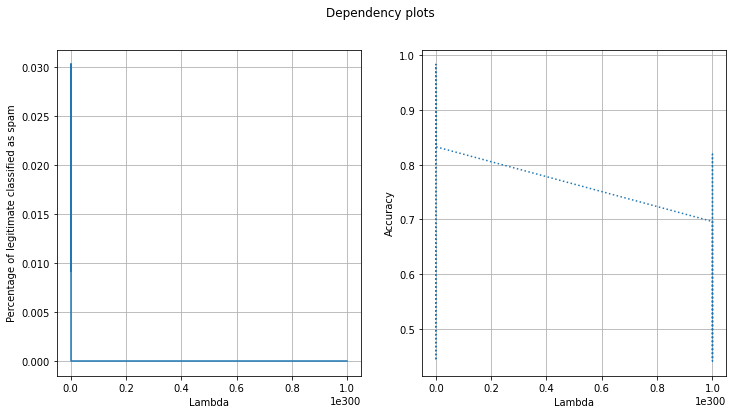

In [111]:
plot_lambda(all_results)

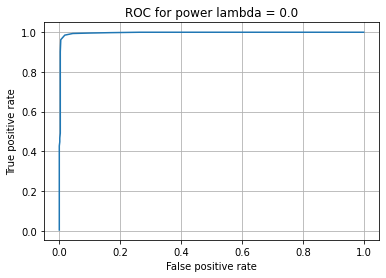

In [58]:
plot_roc(best_assessment)

In [71]:
all_results_short, best_definition_short, best_assessment_short = find_best_short()

Cur params: n_gram=2, alpha=1, cur_lambda=1, cur_weight=1
Cur params: n_gram=2, alpha=1, cur_lambda=100000000000000000000000000000000000000000000000000, cur_weight=1
Cur params: n_gram=2, alpha=1, cur_lambda=10000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000, cur_weight=1
Cur params: n_gram=2, alpha=1, cur_lambda=1000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000, cur_weight=1
Cur params: n_gram=2, alpha=1, cur_lambda=100000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000, cur_weight=1
Cur params: n_gram=2, alpha=1, cur_lambda=100000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000

In [56]:
print_res_ac(best_assessment_short)
print_res_p(best_definition_short)

For best Accuracy n_gram=2, alpha=1, cur_lambda=1, cur_weight=1, assessment=0.9660550458715598
For best Percentage n_gram=2, alpha=1, cur_lambda=10000000000, cur_weight=1, percentage=0.001834862385321101


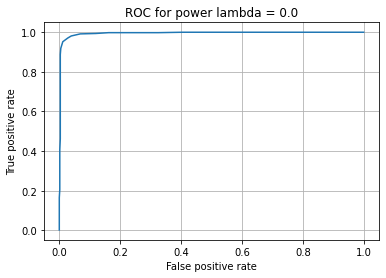

In [59]:
plot_roc(best_assessment_short)

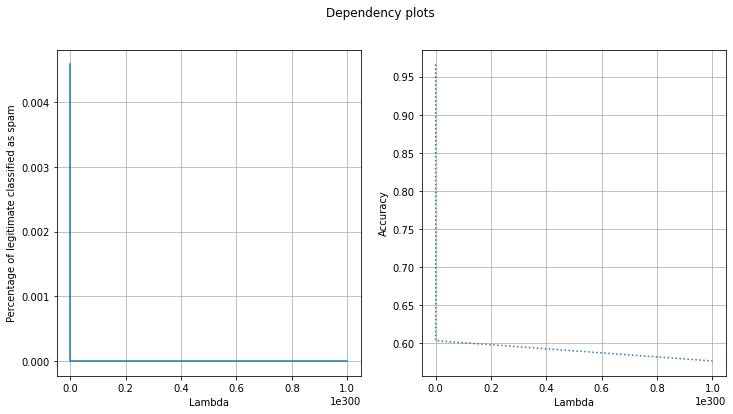

In [112]:
plot_lambda(all_results_short)

In [10]:
print('Total working time: %s seconds.' % (time.time() - start_time))

Total working time: 4613.118151187897 seconds.
